In [1]:
import os
import sys
import urllib, io
import pickle

import numpy as np
import scipy.stats as stats
import pandas as pd

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 
from IPython.core.display import HTML 

from io import BytesIO
import base64

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

In [2]:
experiment_name = 'zipping'

## directory & file hierarchy
proj_dir = os.path.abspath('../..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir = os.path.abspath(os.path.join(os.getcwd(),'..'))
results_dir = os.path.join(proj_dir,'results')

# paths specific to this experiment
experiment_results_dir = os.path.join(results_dir, experiment_name)
plot_dir = os.path.join(experiment_results_dir,'plots')
csv_dir = os.path.join(experiment_results_dir,'csv')
json_dir = os.path.join(experiment_results_dir,'json')

png_dir = os.path.abspath(os.path.join(datavol_dir,'png'))
jefan_dir = os.path.join(analysis_dir,'jefan')
will_dir = os.path.join(analysis_dir,'will')

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       

In [3]:
# set vars 
auth = pd.read_csv(os.path.join(proj_dir, 'auth.txt'), header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'cogtoolslab.org' ## cocolab ip address

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['block_construction']
coll = db['zipping']

# which iteration name should we use?
iteration_name = 'full_1'
iteration_names = [iteration_name]

# variables to check integrity of data
# numTrials = 8

In [4]:
query = coll.find()
df_all = pd.DataFrame(query)
df_all.iterationName.unique()

array(['zipping_prepilot', 'zipping_dev', 'pilot_0', 'pilot_debug',
       'counterbalance_test', 'counterbalance_test_full',
       'counterbalanced_prolific_test', 'full_1_test', 'full_1',
       'full_1_debug'], dtype=object)

In [5]:
query = coll.find({"$and":[
                        {'trial_type':'survey-text'},
#                         {'eventType':'trialEnd'},
                        {'iterationName': { '$in': iteration_names }}, #use this if one iteration name
#                         {'prolificPID': '5b681e2c7a68ea0001ca7f08'}]
                        ]})
df_survey = pd.DataFrame(query)
df_survey

,_id,rt,response,trial_type,trial_index,time_elapsed,internal_node_id,datatype,experimentName,iterationName,workerID,gameID
0,61e7531af8063c6df9fa0aeb,11881.8,"{'technical': 'No', 'confused': 'No', 'comment...",survey-text,169,799033,0.0-169.0,trial_end,block_construction_zipping,full_1,60cfcf833e3822a75a8015b3,2070-312f3517-0043-41bf-892d-7f01efec62fb
1,61e75378f8063c6df9fa0b23,114934.1,"{'technical': 'No', 'confused': 'No', 'comment...",survey-text,169,841421,0.0-169.0,trial_end,block_construction_zipping,full_1,5ce6e7e7023d1600192ff23f,0308-1e8880f9-9ce3-4096-8852-3794ed134725
2,61e75468f8063c6df9fa0be3,9416.2,"{'technical': 'No', 'confused': 'No', 'comment...",survey-text,169,938601,0.0-169.0,trial_end,block_construction_zipping,full_1,5b5a0ed1e56aea000118ad3a,0600-27a36f2f-6c5a-4b84-ba5a-4d1e4c52cbef
3,61e75576f8063c6df9fa0c74,14257.6,"{'technical': 'no', 'confused': 'no', 'comment...",survey-text,169,1031600,0.0-169.0,trial_end,block_construction_zipping,full_1,6107834533a0b2755da4ec85,3880-49177091-625c-4844-a8ae-f76363add62a
4,61e755b8f8063c6df9fa0c75,69805.4,"{'technical': 'no', 'confused': 'no', 'comment...",survey-text,169,871444,0.0-169.0,trial_end,block_construction_zipping,full_1,5e1270f1221dc48d98357c63,6367-edbe16d5-9fa1-4001-8d26-5e26bff1d8b4
...,...,...,...,...,...,...,...,...,...,...,...,...
65,61fdb06df8063c6df9fa37ef,1169646.0,"{'technical': 'no', 'confused': 'no', 'comment...",survey-text,169,1909465,0.0-169.0,trial_end,block_construction_zipping,full_1,5b1efc25bdf4e1000163af46,3604-83dc67f7-a9ec-43ef-8463-1f01bd775072
66,61fdb080f8063c6df9fa37f4,37693.4,"{'technical': 'No', 'confused': 'N/A', 'commen...",survey-text,169,1867157,0.0-169.0,trial_end,block_construction_zipping,full_1,594abd98215cbd000146debc,0168-92174b92-e912-4287-9cf4-57b5e922ef34
67,61fdb09ff8063c6df9fa37fa,9256.7,"{'technical': '', 'confused': '', 'comments': ''}",survey-text,169,1939838,0.0-169.0,trial_end,block_construction_zipping,full_1,5ce9c6df6b2b3d001a94b24f,3593-be8d96dc-6d23-4e67-94d2-740982288e70
68,61fdb124f8063c6df9fa37ff,294208.1,"{'technical': 'No.', 'confused': 'No.', 'comme...",survey-text,169,1072263,0.0-169.0,trial_end,block_construction_zipping,full_1,609478fa9e5b4d075246cfaf,0328-7f499abf-a251-4c7b-a57d-a2684a56b70d


In [6]:
query = coll.find({"$and":[
                        {'trial_type':'block-construction'},
#                         {'eventType':'trialEnd'},
                        {'iterationName': { '$in': iteration_names }}, #use this if one iteration name
#                         {'prolificPID': '5b681e2c7a68ea0001ca7f08'}]
                        ]})
df_build = pd.DataFrame(query)
df_build

,_id,timeAbsolute,timeRelative,blocks,discreteWorld,eventType,endReason,stimURL,stimulus,stimId,...,chunk_type,trial_type,trial_index,time_elapsed,internal_node_id,datatype,experimentName,iterationName,workerID,gameID
0,61e74ff5f8063c6df9fa0919,1.642549e+12,99559,"[{'x': 5, 'y': 0, 'width': 1, 'height': 2}, {'...","[[True, True, True, True, True, True, True, Tr...",trial_end,perfect-reconstruction-translation,https://lax-tower-4-block-unique-silhouettes-j...,"{'blocks': [{'x': 0, 'y': 0, 'height': 2, 'wid...",025,...,wide,block-construction,2,98337,0.0-2.0,trial_end,block_construction_zipping,full_1,5fb706937e9d501cc1c5795d,6828-afa0f5aa-c658-42d6-9057-77ca52425e66
1,61e7500df8063c6df9fa091b,1.642549e+12,124000,"[{'x': 5, 'y': 0, 'width': 1, 'height': 2}, {'...","[[True, True, True, True, True, True, True, Tr...",trial_end,perfect-reconstruction-translation,https://lax-tower-4-block-unique-silhouettes-j...,"{'blocks': [{'x': 0, 'y': 0, 'height': 2, 'wid...",102,...,tall,block-construction,3,122777,0.0-3.0,trial_end,block_construction_zipping,full_1,5fb706937e9d501cc1c5795d,6828-afa0f5aa-c658-42d6-9057-77ca52425e66
2,61e75015f8063c6df9fa091c,1.642549e+12,131566,"[{'x': 5, 'y': 0, 'width': 1, 'height': 2}, {'...","[[True, True, True, True, True, True, True, Tr...",trial_end,perfect-reconstruction-translation,https://lax-tower-4-block-unique-silhouettes-j...,"{'blocks': [{'x': 1, 'y': 0, 'height': 2, 'wid...",126,...,tall,block-construction,4,130344,0.0-4.0,trial_end,block_construction_zipping,full_1,5fb706937e9d501cc1c5795d,6828-afa0f5aa-c658-42d6-9057-77ca52425e66
3,61e7501bf8063c6df9fa091d,1.642549e+12,138201,"[{'x': 5, 'y': 0, 'width': 2, 'height': 1}, {'...","[[True, True, True, True, True, True, True, Tr...",trial_end,perfect-reconstruction-translation,https://lax-tower-4-block-unique-silhouettes-j...,"{'blocks': [{'x': 1, 'y': 0, 'height': 2, 'wid...",023,...,wide,block-construction,5,136978,0.0-5.0,trial_end,block_construction_zipping,full_1,5fb706937e9d501cc1c5795d,6828-afa0f5aa-c658-42d6-9057-77ca52425e66
4,61e75023f8063c6df9fa091e,1.642549e+12,145364,"[{'x': 5, 'y': 0, 'width': 1, 'height': 2}, {'...","[[True, True, True, True, True, True, True, Tr...",trial_end,perfect-reconstruction-translation,https://lax-tower-4-block-unique-silhouettes-j...,"{'blocks': [{'x': 0, 'y': 0, 'height': 2, 'wid...",102,...,tall,block-construction,6,144141,0.0-6.0,trial_end,block_construction_zipping,full_1,5fb706937e9d501cc1c5795d,6828-afa0f5aa-c658-42d6-9057-77ca52425e66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1185,61fdb175f8063c6df9fa3802,1.644016e+12,2023979,"[{'x': 4, 'y': 0, 'width': 2, 'height': 1}, {'...","[[True, True, True, True, True, True, True, Tr...",trial_end,perfect-reconstruction-translation,https://lax-tower-4-block-unique-silhouettes-j...,"{'blocks': [{'x': 0, 'y': 0, 'height': 1, 'wid...",100,...,tall,block-construction,13,2022929,0.0-13.0,trial_end,block_construction_zipping,full_1,606e4eb2a56685e5593304cd,7339-49754e00-a36d-42e0-b56f-64decbdf55b5
1186,61fdb19ef8063c6df9fa3803,1.644016e+12,2065010,"[{'x': 4, 'y': 0, 'width': 1, 'height': 2}, {'...","[[True, True, True, True, True, True, True, Tr...",trial_end,perfect-reconstruction-translation,https://lax-tower-4-block-unique-silhouettes-j...,"{'blocks': [{'x': 0, 'y': 0, 'height': 2, 'wid...",024,...,wide,block-construction,14,2063960,0.0-14.0,trial_end,block_construction_zipping,full_1,606e4eb2a56685e5593304cd,7339-49754e00-a36d-42e0-b56f-64decbdf55b5
1187,61fdb1acf8063c6df9fa3804,1.644016e+12,2079277,"[{'x': 4, 'y': 0, 'width': 2, 'height': 1}, {'...","[[True, True, True, True, True, True, True, Tr...",trial_end,perfect-reconstruction-translation,https://lax-tower-4-block-unique-silhouettes-j...,"{'blocks': [{'x': 0, 'y': 0, 'height': 1, 'wid...",011,...,wide,block-construction,15,2078227,0.0-15.0,trial_end,block_construction_zipping,full_1,606e4eb2a56685e5593304cd,7339-49754e00-a36d-42e0-b56f-64decbdf55b5
1188,61fdb1

In [7]:
query = coll.find({"$and":[
                        {'trial_type':'tower-zipping'},
#                         {'eventType':'trialEnd'},
                        {'iterationName': { '$in': iteration_names}}, #use this if one iteration name
#                         {'prolificPID': '5b681e2c7a68ea0001ca7f08'}]
                        ]})
df_zip = pd.DataFrame(query)
df_zip

,_id,rt,stimulus,response,response_correct,stimURL,composite_id,rep,block_number,composite_duration,...,trial_type,trial_index,time_elapsed,internal_node_id,datatype,experimentName,iterationName,workerID,gameID,trial_num
0,61e7515bf8063c6df9fa094a,2089.9,https://tower-4-block-unique-silhouettes-compo...,m,0,https://tower-4-block-unique-silhouettes-compo...,talls_100_118,0,0,50,...,tower-zipping,21,300024,0.0-21.0,trial_end,block_construction_zipping,full_1,5ce6e7e7023d1600192ff23f,0308-1e8880f9-9ce3-4096-8852-3794ed134725,NaN
1,61e7515ff8063c6df9fa094b,2305.8,https://tower-4-block-unique-silhouettes-compo...,m,0,https://tower-4-block-unique-silhouettes-compo...,talls_102_126,0,0,50,...,tower-zipping,22,304053,0.0-22.0,trial_end,block_construction_zipping,full_1,5ce6e7e7023d1600192ff23f,0308-1e8880f9-9ce3-4096-8852-3794ed134725,NaN
2,61e75164f8063c6df9fa094d,3506.2,https://tower-4-block-unique-silhouettes-compo...,z,1,https://tower-4-block-unique-silhouettes-compo...,talls_100_118,0,0,50,...,tower-zipping,23,309281,0.0-23.0,trial_end,block_construction_zipping,full_1,5ce6e7e7023d1600192ff23f,0308-1e8880f9-9ce3-4096-8852-3794ed134725,NaN
3,61e75167f8063c6df9fa094e,1411.5,https://tower-4-block-unique-silhouettes-compo...,m,1,https://tower-4-block-unique-silhouettes-compo...,talls_102_126,0,0,50,...,tower-zipping,24,312439,0.0-24.0,trial_end,block_construction_zipping,full_1,5ce6e7e7023d1600192ff23f,0308-1e8880f9-9ce3-4096-8852-3794ed134725,NaN
4,61e7516af8063c6df9fa0950,1206.3,https://tower-4-block-unique-silhouettes-compo...,z,1,https://tower-4-block-unique-silhouettes-compo...,talls_100_118,0,0,50,...,tower-zipping,25,315383,0.0-25.0,trial_end,block_construction_zipping,full_1,5ce6e7e7023d1600192ff23f,0308-1e8880f9-9ce3-4096-8852-3794ed134725,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10197,61fdb447f8063c6df9fa3899,1821.6,https://tower-4-block-unique-silhouettes-compo...,m,1,https://tower-4-block-unique-silhouettes-compo...,talls_122_127,3,2,200,...,tower-zipping,164,2744616,0.0-164.0,trial_end,block_construction_zipping,full_1,606e4eb2a56685e5593304cd,7339-49754e00-a36d-42e0-b56f-64decbdf55b5,140.0
10198,61fdb44af8063c6df9fa389a,1761.0,https://tower-4-block-unique-silhouettes-compo...,z,1,https://tower-4-block-unique-silhouettes-compo...,talls_102_126,3,2,200,...,tower-zipping,165,2748131,0.0-165.0,trial_end,block_construction_zipping,full_1,606e4eb2a56685e5593304cd,7339-49754e00-a36d-42e0-b56f-64decbdf55b5,141.0
10199,61fdb44df8063c6df9fa389b,758.3,https://tower-4-block-unique-silhouettes-compo...,m,1,https://tower-4-block-unique-silhouettes-compo...,talls_100_118,3,2,200,...,tower-zipping,166,2750731,0.0-166.0,trial_end,block_construction_zipping,full_1,606e4eb2a56685e5593304cd,7339-49754e00-a36d-42e0-b56f-64decbdf55b5,142.0
10200,61fdb450f8063c6df9fa389c,1355.2,https://tower-4-block-unique-silhouettes-compo...,z,1,https://tower-4-block-unique-silhouettes-compo...,talls_102_126,3,2,200,...,tower-zipping,167,2753923,0.0-167.0,trial_end,block_construction_zipping,full_1,606e4eb2a56685e5593304cd,7339-49754e00-a36d-42e0-b56f-64decbdf55b5,143.0


In [8]:
df_zip.columns

Index(['_id', 'rt', 'stimulus', 'response', 'response_correct', 'stimURL',
       'composite_id', 'rep', 'block_number', 'composite_duration',
       'gap_duration', 'chunk_duration', 'participant_condition',
       'compatible_trial', 'validity', 'composite_talls_name',
       'composite_wides_name', 'part_type', 'part_a', 'part_b',
       'participantRotationName', 'participantRotation', 'stimVersion',
       'stimVersionInd', 'compatible_condition', 'trial_type', 'trial_index',
       'time_elapsed', 'internal_node_id', 'datatype', 'experimentName',
       'iterationName', 'workerID', 'gameID', 'trial_num'],
      dtype='object')

### Remove identifiable info

In [9]:
df_zip = df_zip.drop('workerID', axis='columns')

In [10]:
df_zip.to_csv('df_zipping_{}.csv'.format(iteration_name))

### Add useful columns

In [11]:
df_zip['compatibility'] = 'none'
df_zip.loc[df_zip.compatible_condition == df_zip.participant_condition, 'compatibility'] = 'compatible'
df_zip.loc[df_zip.compatible_condition != df_zip.participant_condition, 'compatibility'] = 'incompatible'
df_zip.loc[df_zip.compatible_condition == 0,'compatibility'] = 'novel'

In [12]:
df_zip.loc[:,'trial_bin'] = np.round(df_zip.trial_index/12)

### Apply exclusion criteria

In [13]:
# complete datasets
full_dataset_ids = (df_zip.groupby('gameID').apply(len) == 144).index[(df_zip.groupby('gameID').apply(len) == 144)]
df_zip = df_zip.loc[df_zip.gameID.isin(full_dataset_ids)]

In [14]:
# low accuracy
p = df_zip.groupby('gameID').response_correct.mean() > 0.65
ppt_greater_chance = list(p[p].index)
print(str(len(df_zip.groupby('gameID')) - len(ppt_greater_chance)) + ' ppts removed')

df_zip = df_zip[df_zip.gameID.isin(ppt_greater_chance)].reset_index()
print(str(len(ppt_greater_chance)) + ' ppts left')


19 ppts removed
51 ppts left


In [52]:
# exclude really slow ppts

df_zip_ppt_means = df_zip.groupby(['gameID']).mean()

df_zip = df_zip[~df_zip.gameID.isin(list(df_zip_ppt_means['rt'].index[df_zip_ppt_means['rt'] > 5000]))]

print(str(df_zip.gameID.nunique()) + ' ppts left')

50 ppts left


In [53]:
# fast RTs
df_zip.loc[:,'flagRT'] = False
df_zip.loc[(df_zip.rt > 5000), 'flagRT'] = True

In [54]:
df_zip['flagRT'].sum()

12

In [ ]:
# recalculate ppt means with 
df_zip_ppt_means = df_zip.groupby(['gameID']).mean()

In [217]:
df_zip.to_csv('../../results/zipping/csv/df_zip_{}_tmp.csv'.format(iteration_name))

In [204]:
df = df_zip.groupby(['composite_duration','participantRotationName','participant_condition','gameID']).first().reset_index()
df2 = df.groupby(['composite_duration','participantRotationName','participant_condition']).apply(len).reset_index()
df2 = df2.rename(columns={0:'n_ppt'})
df2

,composite_duration,participantRotationName,participant_condition,n_ppt
0,50,p,1,1
1,50,p,2,3
2,50,q,1,2
3,50,q,2,2
4,50,r,1,4
5,50,r,2,3
6,100,p,1,4
7,100,p,2,4
8,100,q,1,4
9,100,q,2,3


In [211]:
n_expected = 3
extra_metadata = []

for duration in [50,100,200]:
    for rotationName in ['p','q','r']:
        for condition in [1,2]:
            n = print(df2[(df2.composite_duration == duration) &
                      (df2.participantRotationName == rotationName) &
                     (df2.participant_condition == condition)]['n_ppt'].sum())
            
            while n < n_expected:
                extra_metadata.append()

1
3
2
2
4
3
4
4
4
3
2
4
5
4
0
2
3
0


#### Fix data with missing columns

In [55]:
# A handful of participants only had trial_index saved, which is an index that includes instruction 'trials' etc.
# Add more useful 'trial_num'

# get mapping of trial index to trial num
trial_index_to_num = df_zip[df_zip.gameID=="2594-e6a6440c-39e9-49e8-a20d-0a9e752d70e6"]\
[['trial_index','trial_num']].reset_index(drop=True)

df_zip = df_zip.merge(trial_index_to_num, how='left', on='trial_index')
df_zip['trial_num'] = df_zip['trial_num_x'].fillna(df_zip['trial_num_y'])
df_zip = df_zip.drop(['trial_num_x','trial_num_y'], axis=1)

### plot setup

In [56]:
sns.set_context('poster')
sns.set(font_scale=1.2)
sns.set_style('whitegrid', {'font.family':'sans-serif', 'font.sans-serif':'Avenir'})

### accuracy

<AxesSubplot:xlabel='composite_duration', ylabel='response_correct'>

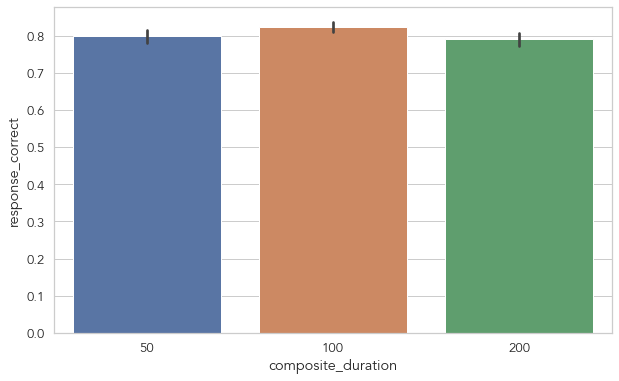

In [57]:
fig = plt.figure(figsize=(10,6))

sns.barplot(data=df_zip, 
              y="response_correct", 
              x="composite_duration")
#               hue="gameID")
# plt.legend(bbox_to_anchor=(1.0,1))

No handles with labels found to put in legend.


Text(0.5, 1.0, 'accuracy')

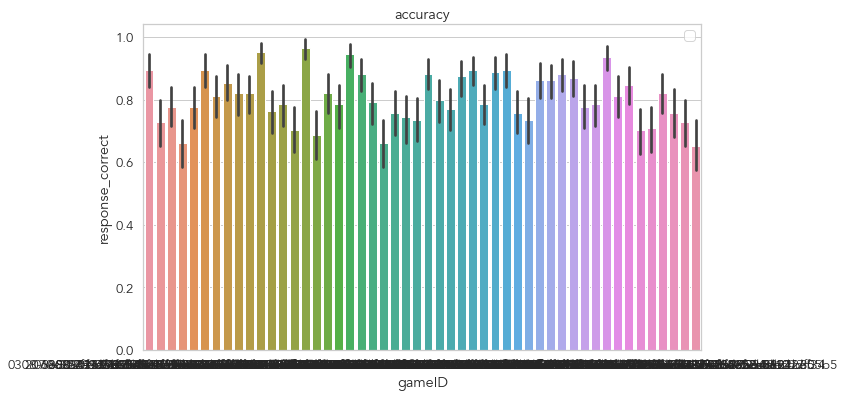

In [65]:
fig = plt.figure(figsize=(10,6))

sns.barplot(data=df_zip, 
              y="response_correct", 
              x="gameID")
#               hue="gameID")
plt.legend(bbox_to_anchor=(1.0,1))
plt.title('accuracy')

No handles with labels found to put in legend.


Text(0.5, 1.0, 'RT')

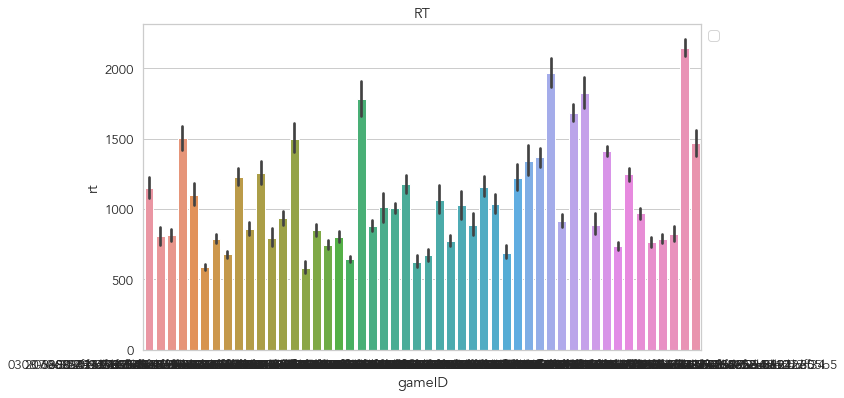

In [66]:
fig = plt.figure(figsize=(10,6))

sns.barplot(data=df_zip[~df_zip['flagRT']], 
              y="rt", 
              x="gameID")
plt.legend(bbox_to_anchor=(1.0,1))
plt.title('RT')

## Compatibility

In [78]:
compatibility_order = ['novel','compatible','incompatible']

### Accuracy

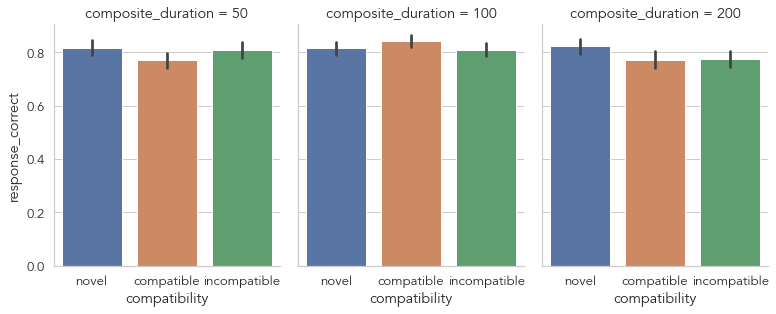

In [79]:
# Are people more accurate in compatible trials?

g = sns.catplot(col="composite_duration", 
#                 x="validity",
                y="response_correct", 
                x="compatibility",
                order=compatibility_order,
                dodge=True,
                kind="bar",
                data=df_zip,
                height=4.6,
                aspect=0.8)

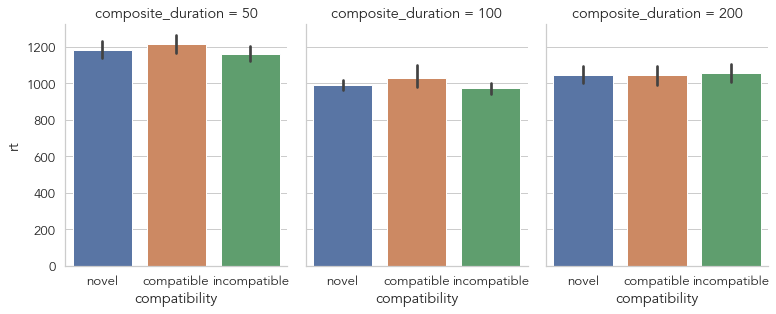

In [80]:
# Are people more accurate in compatible trials?

g = sns.catplot(col="composite_duration", 
#                 x="validity",
                y="rt", 
                x="compatibility",
                order=compatibility_order,
                dodge=True,
                kind="bar",
                data=df_zip,
                height=4.6,
                aspect=0.8)

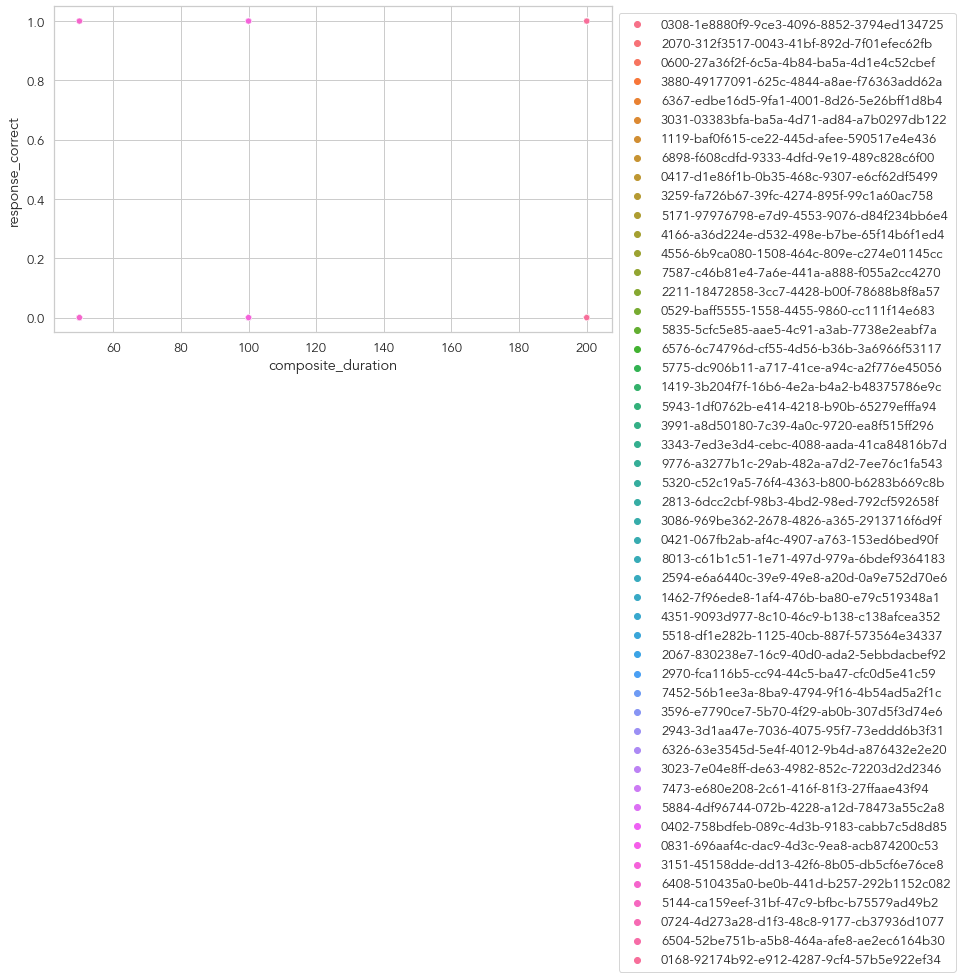

In [46]:
fig = plt.figure(figsize=(10,6))

sns.scatterplot(data=df_zip, 
              y="response_correct",
              x="composite_duration",
              hue="gameID")
plt.legend(bbox_to_anchor=(1.0,1))

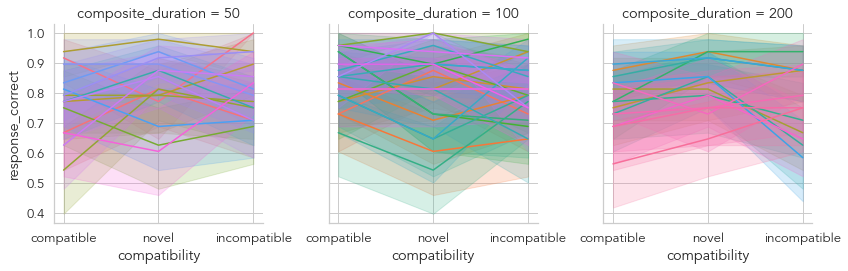

In [86]:
g = sns.FacetGrid(df_zip, col="composite_duration", height=4, hue='gameID',)
g.map(sns.lineplot, 
      "compatibility",
      "response_correct");

No handles with labels found to put in legend.


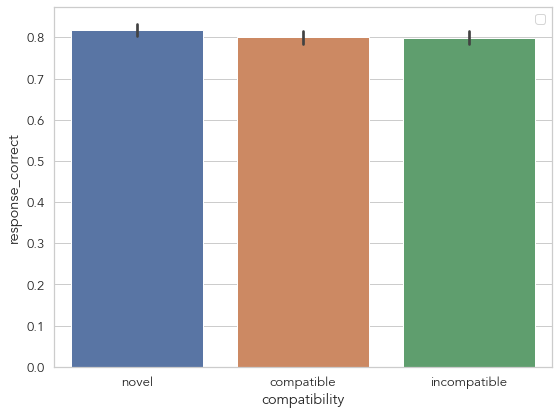

In [87]:
# Are people more accurate in compatible trials?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip, 
                y= "response_correct",
                x = "compatibility",
                order = compatibility_order)

plt.tight_layout()
plt.legend(bbox_to_anchor=(1.0,1))

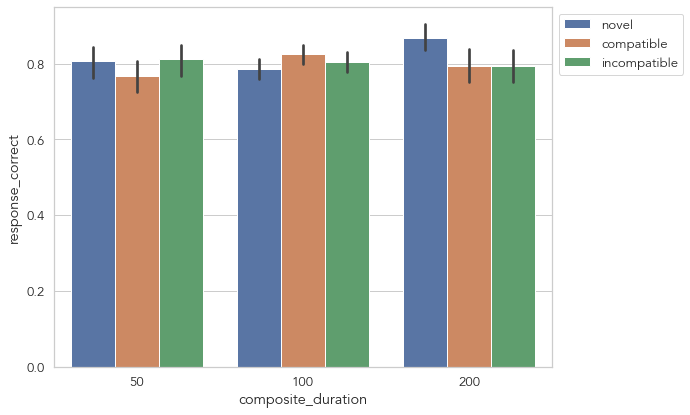

In [383]:
# Are people more accurate in compatible trials?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip, 
                y= "response_correct",
                x = "composite_duration",
                hue= "compatibility", 
                hue_order=['novel','compatible','incompatible'])

plt.tight_layout()
plt.legend(bbox_to_anchor=(1.0,1))

### RT

/Users/will/opt/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/will/opt/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='rt', ylabel='Density'>

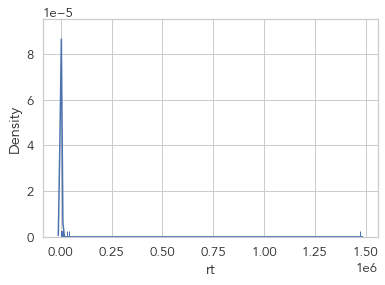

In [382]:
# sns.distplot(data=df_zip, y='rt', x="trial_index")
sns.distplot(df_zip.rt, rug=True, hist=False)

<AxesSubplot:xlabel='rt', ylabel='Count'>

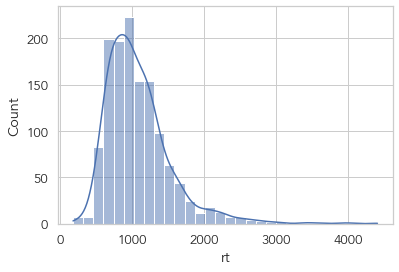

In [221]:
# sns.distplot(df_zip[(~df_zip.flagRT)].rt, rug=True, hist=False)

sns.histplot(data=df_zip[(~df_zip.flagRT)], x="rt", bins=30, kde=True)

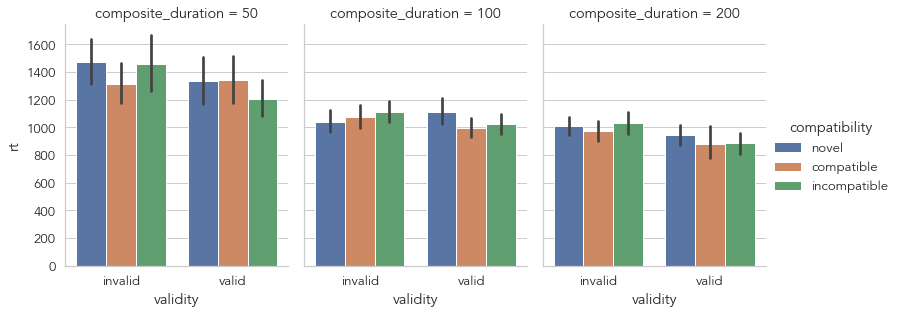

In [222]:
# Are people faster in compatible trials?

g = sns.catplot(col="composite_duration", 
                x="validity",
                y="rt", 
                hue="compatibility",
                hue_order=['novel','compatible','incompatible'],
                dodge=True,
                kind="bar",
                data=df_zip[~df_zip.flagRT],
                height=4.6,
                aspect=0.8)

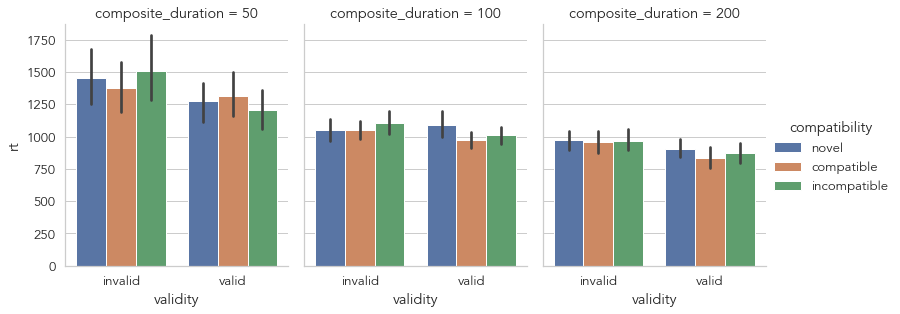

In [223]:
# correct responses only
# Are people faster in compatible trials

g = sns.catplot(col="composite_duration", 
                x="validity",
                y="rt", 
                hue="compatibility",
                hue_order=['novel','compatible','incompatible'],
                dodge=True,
                kind="bar",
                data=df_zip[(~df_zip.flagRT) & (df_zip.response_correct)],
                height=4.6,
                aspect=0.8)

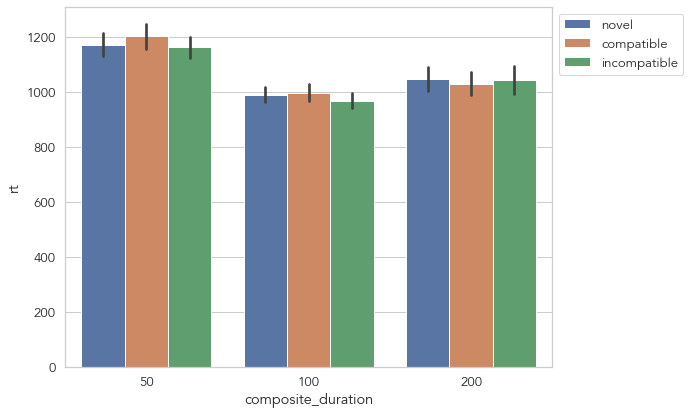

In [177]:
# Are people faster in compatible trials?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip[~df_zip.flagRT], 
                y= "rt",
                x = "composite_duration",
                hue= "compatibility", 
                hue_order=compatibility_order)

plt.tight_layout()
plt.legend(bbox_to_anchor=(1.0,1))

No handles with labels found to put in legend.


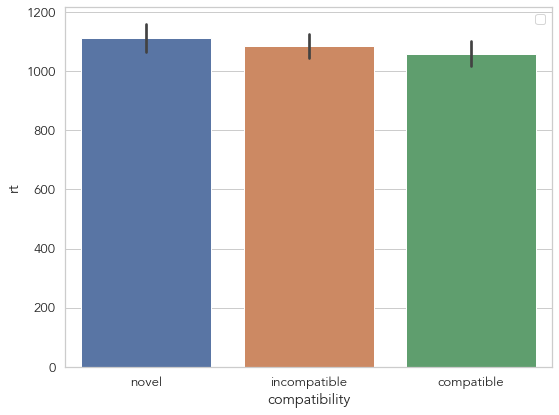

In [225]:
# Are people faster in compatible trials?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip[~df_zip.flagRT], 
                y= "rt",
#                 x = "composite_duration",
                x= "compatibility")# , hue_order=['novel','compatible','incompatible'])

plt.tight_layout()
plt.legend(bbox_to_anchor=(1.0,1))

In [226]:
df_zip

,Unnamed: 0,index,_id,rt,stimulus,response,response_correct,stimURL,composite_id,rep,...,time_elapsed,internal_node_id,datatype,experimentName,iterationName,workerID,gameID,compatibility,trial_bin,flagRT
0,0,0,61ba50212dda677e2c8a7c42,1393.699999,https://tower-4-block-unique-silhouettes-compo...,z,1,https://tower-4-block-unique-silhouettes-compo...,talls_122_127,0,...,343072,0.0-21.0,trial_end,block_construction_zipping,counterbalanced_prolific_test,5ec937780f01f642f4dfd6c2,5932-1c8afdaa-3e62-4179-89e1-cac0c71b27a1,novel,2.0,False
1,1,1,61ba50262dda677e2c8a7c45,1897.299999,https://tower-4-block-unique-silhouettes-compo...,m,0,https://tower-4-block-unique-silhouettes-compo...,talls_102_126,0,...,348244,0.0-22.0,trial_end,block_construction_zipping,counterbalanced_prolific_test,5ec937780f01f642f4dfd6c2,5932-1c8afdaa-3e62-4179-89e1-cac0c71b27a1,incompatible,2.0,False
2,2,2,61ba502b2dda677e2c8a7c49,1675.699999,https://tower-4-block-unique-silhouettes-compo...,z,1,https://tower-4-block-unique-silhouettes-compo...,talls_122_127,0,...,353182,0.0-23.0,trial_end,block_construction_zipping,counterbalanced_prolific_test,5ec937780f01f642f4dfd6c2,5932-1c8afdaa-3e62-4179-89e1-cac0c71b27a1,novel,2.0,False
3,3,3,61ba50302dda677e2c8a7c4a,1735.799999,https://tower-4-block-unique-silhouettes-compo...,z,1,https://tower-4-block-unique-silhouettes-compo...,talls_102_126,0,...,358006,0.0-24.0,trial_end,block_construction_zipping,counterbalanced_prolific_test,5ec937780f01f642f4dfd6c2,5932-1c8afdaa-3e62-4179-89e1-cac0c71b27a1,incompatible,2.0,False
4,4,4,61ba50352dda677e2c8a7c4d,1948.300001,https://tower-4-block-unique-silhouettes-compo...,m,1,https://tower-4-block-unique-silhouettes-compo...,talls_100_118,0,...,363320,0.0-25.0,trial_end,block_construction_zipping,counterbalanced_prolific_test,5ec937780f01f642f4dfd6c2,5932-1c8afdaa-3e62-4179-89e1-cac0c71b27a1,incompatible,2.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1327,1327,1471,61ba7e552dda677e2c8a82f4,673.300000,https://tower-4-block-unique-silhouettes-compo...,m,1,https://tower-4-block-unique-silhouettes-compo...,talls_102_126,3,...,933454,0.0-164.0,trial_end,block_construction_zipping,counterbalanced_prolific_test,61280902667000b761f45570,6103-27acfb95-944a-43dd-9c19-1a9b2bc27f86,compatible,14.0,False
1328,1328,1472,61ba7e582dda677e2c8a82f5,901.000000,https://tower-4-block-unique-silhouettes-compo...,m,1,https://tower-4-block-unique-silhouettes-compo...,talls_100_118,3,...,936365,0.0-165.0,trial_end,block_construction_zipping,counterbalanced_prolific_test,61280902667000b761f45570,6103-27acfb95-944a-43dd-9c19-1a9b2bc27f86,novel,14.0,False
1329,1329,1473,61ba7e5a2dda677e2c8a82f7,670.900000,https://tower-4-block-unique-silhouettes-compo...,z,1,https://tower-4-block-unique-silhouettes-compo...,talls_100_118,3,...,939099,0.0-166.0,trial_end,block_construction_zipping,counterbalanced_prolific_test,61280902667000b761f45570,6103-27acfb95-944a-43dd-9c19-1a9b2bc27f86,novel,14.0,False
1330,1330,1474,61ba7e5d2dda677e2c8a82f8,733.900000,https://tower-4-block-unique-silhouettes-compo...,m,0,https://tower-4-block-unique-silhouettes-compo...,talls_122_127,3,...,941959,0.0-167.0,trial_end,block_construction_zipping,counterbalanced_prolific_test,61280902667000b761f45570,6103-27acfb95-944a-43dd-9c19-1a9b2bc27f86,compatible,14.0,False


### Is there a speed accuracy trade-off?

In [69]:
df_zip_ppt_means = df_zip.groupby(['gameID']).mean()

<AxesSubplot:xlabel='response_correct', ylabel='rt'>

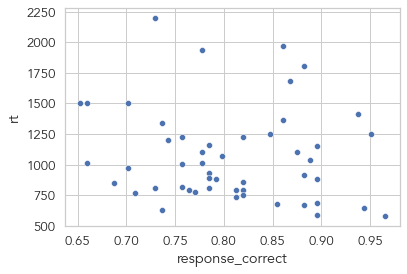

In [70]:
# are people responding slower 

sns.scatterplot(data=df_zip_ppt_means,
               y='rt',
               x='response_correct')

No handles with labels found to put in legend.


Text(0.5, 1.0, 'RT')

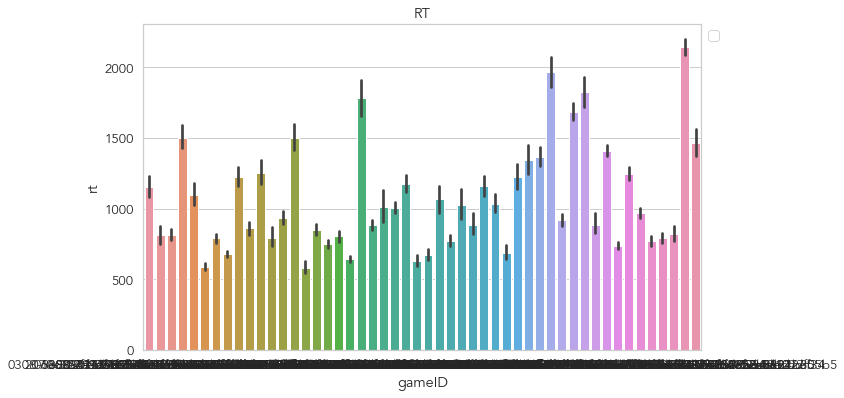

In [72]:
fig = plt.figure(figsize=(10,6))

sns.barplot(data=df_zip[~df_zip['flagRT']], 
              y="rt", 
              x="gameID")
plt.legend(bbox_to_anchor=(1.0,1))
plt.title('RT')

No handles with labels found to put in legend.


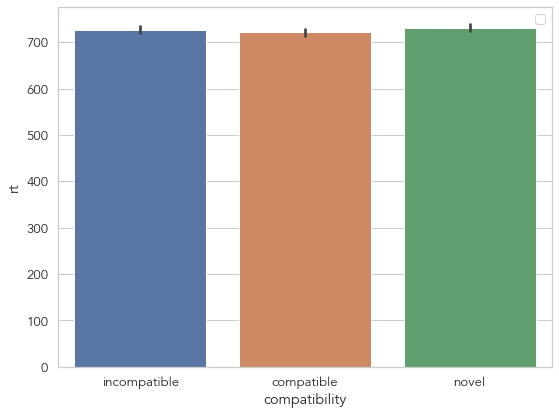

In [191]:
# Is something different going on when people respond quickly?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip[df_zip.rt<1000], 
                y= "rt",
#                 x = "composite_duration",
                x= "compatibility")# , hue_order=['novel','compatible','incompatible'])

plt.tight_layout()
plt.legend(bbox_to_anchor=(1.0,1))

### Duration

How does the amount of time the composite stimulus is displayed for affect things?

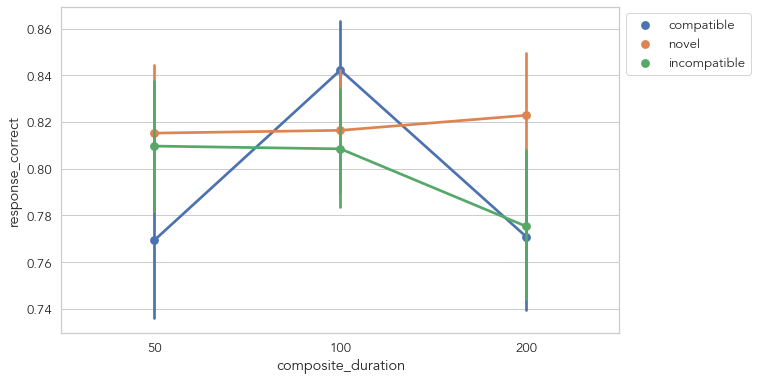

In [190]:
fig = plt.figure(figsize=(10,6))
sns.pointplot(data=df_zip, 
              y="response_correct", 
              x="composite_duration",
              hue="compatibility")
plt.legend(bbox_to_anchor=(1.0,1))

<AxesSubplot:xlabel='composite_duration', ylabel='rt'>

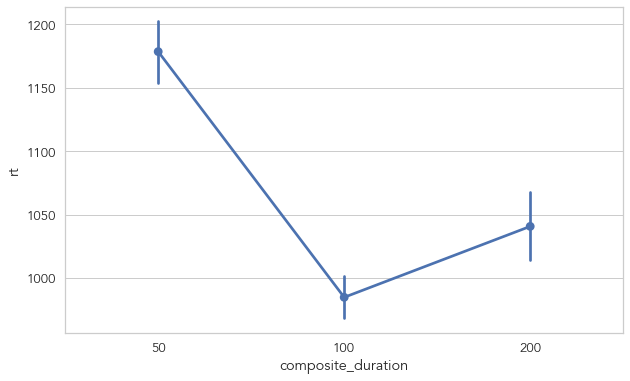

In [175]:
fig = plt.figure(figsize=(10,6))

sns.pointplot(data=df_zip[~df_zip.flagRT], 
              y="rt", 
              x="composite_duration")

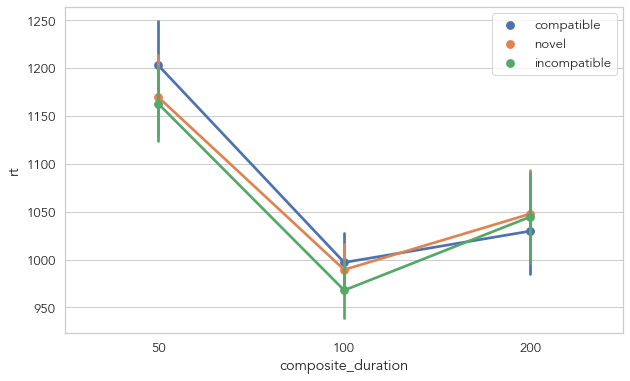

In [189]:
fig = plt.figure(figsize=(10,6))

sns.pointplot(data=df_zip[~df_zip.flagRT], 
              y="rt",
              x="composite_duration",
              hue="compatibility")
plt.legend(bbox_to_anchor=(1.0,1))

# Learning effects

Looks like there are substantial learning effects

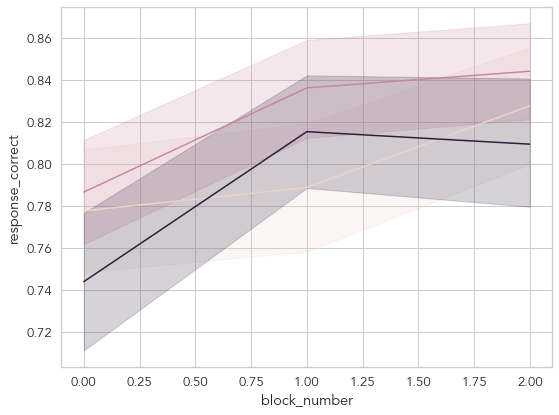

In [157]:
fig = plt.figure(figsize=(8,6))

c = sns.lineplot(data=df_zip, 
                y= "response_correct", 
                x= "block_number",
                hue="composite_duration",
#                 ci=None,
                legend=None)
# plt.legend(bbox_to_anchor=(1.0,1))

plt.tight_layout()

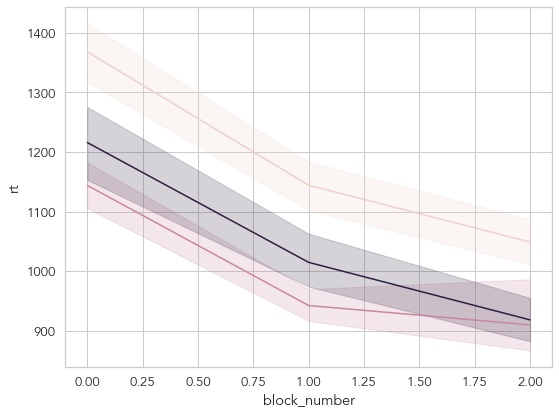

In [159]:
fig = plt.figure(figsize=(8,6))

c = sns.lineplot(data=df_zip, 
                y= "rt", 
                x= "block_number",
                hue="composite_duration",
#                 ci=None,
                legend=None)
# plt.legend(bbox_to_anchor=(1.0,1))

plt.tight_layout()

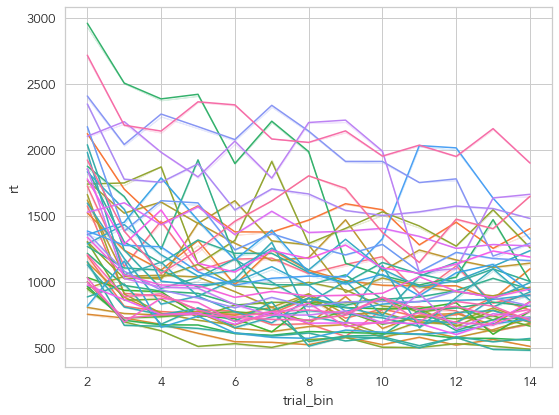

In [161]:
fig = plt.figure(figsize=(8,6))

c = sns.lineplot(data=df_zip[~df_zip.flagRT], 
                y= "rt",
                x = "trial_bin",
                hue= "gameID",
                ci=False,
                legend=False)

plt.tight_layout()

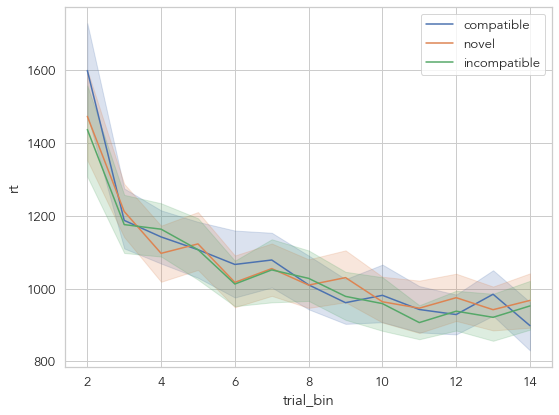

In [165]:
fig = plt.figure(figsize=(8,6))

c = sns.lineplot(data=df_zip[~df_zip.flagRT], 
                y= "rt",
                x = "trial_bin",
                hue= "compatibility")
plt.legend(bbox_to_anchor=(1.0,1))

plt.tight_layout()

### Do people become more accurate over time?

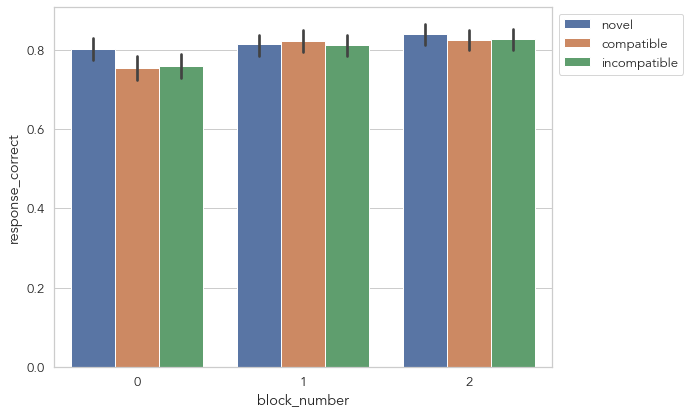

In [94]:
# over blocks (of 48 trials)?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip, 
                y= "response_correct",
                x = "block_number",
                hue = "compatibility",
                hue_order = compatibility_order,)

plt.tight_layout()
plt.legend(bbox_to_anchor=(1.0,1))

They do get a bit better

Let's see if this happens for all durations

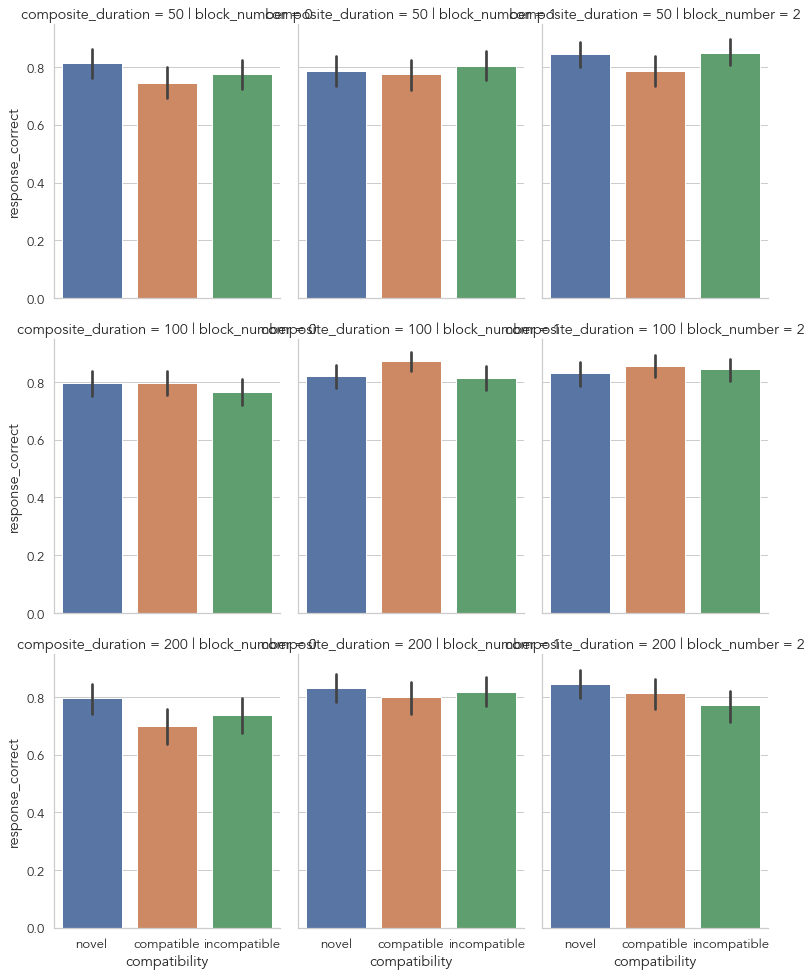

In [95]:
# rt over blocks, broken down by duration

g = sns.catplot(col="block_number",
                row="composite_duration", 
                y="response_correct", 
                x="compatibility",
                order=compatibility_order,
                dodge=True,
                kind="bar",
                data=df_zip,
                height=4.6,
                aspect=0.8)

### RT over time

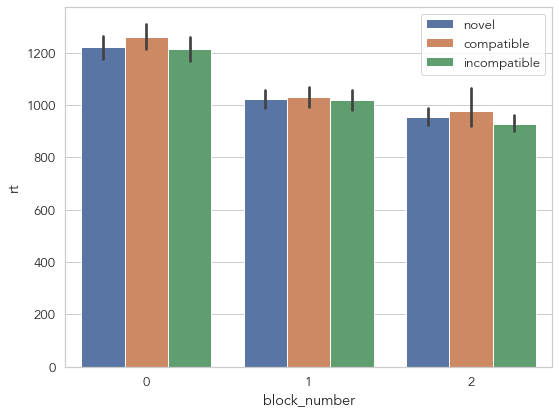

In [96]:
# over blocks (of 48 trials)?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip, 
                y= "rt",
                x = "block_number",
                hue = "compatibility",
                hue_order = compatibility_order,)

plt.tight_layout()
plt.legend(bbox_to_anchor=(1.0,1))

They get a lot faster with practice!

Let's see if this happens for all durations

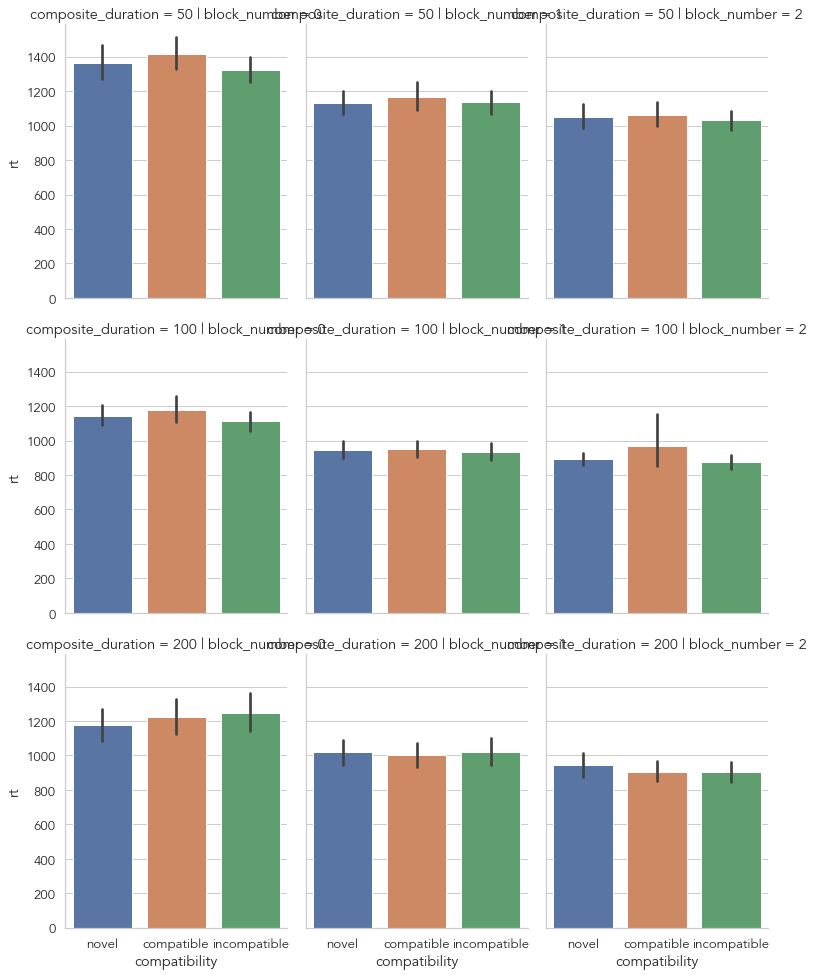

In [97]:
# rt over blocks, broken down by duration

g = sns.catplot(col="block_number",
                row="composite_duration", 
                y="rt", 
                x="compatibility",
                order=compatibility_order,
                dodge=True,
                kind="bar",
                data=df_zip,
                height=4.6,
                aspect=0.8)

### Validity

Looks like valid trials might be a little easier

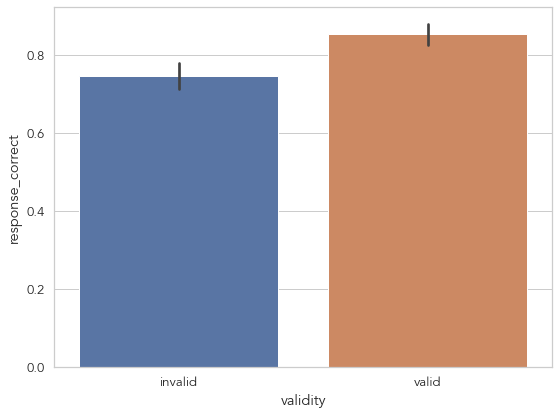

In [232]:
# are valid trials more accurate?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip, 
                y= "response_correct", 
                x="validity"
                )

plt.tight_layout()

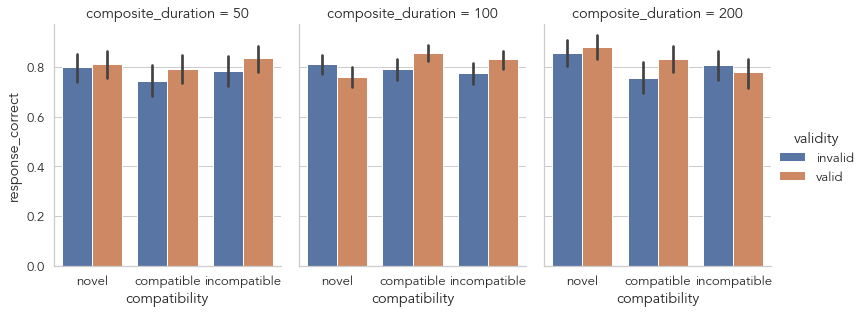

In [368]:
# Are people more accurate in valid trials in all conditions?

g = sns.catplot(col="composite_duration", 
                hue="validity",
                y="response_correct", 
                x="compatibility",
                order=['novel','compatible','incompatible'],
                dodge=True,
                kind="bar",
                data=df_zip,
                height=4.6,
                aspect=0.8)

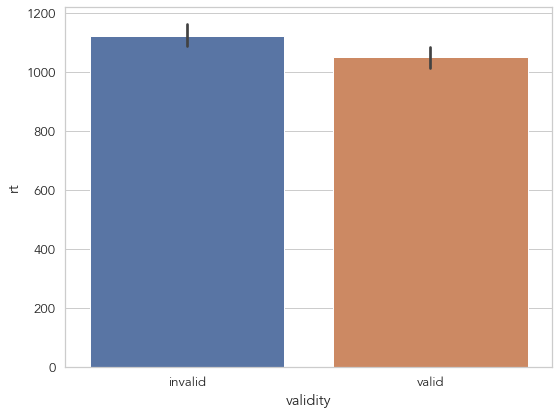

In [234]:
# are valid trials faster?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip[~df_zip.flagRT], 
                y= "rt", 
                x="validity")

plt.tight_layout()

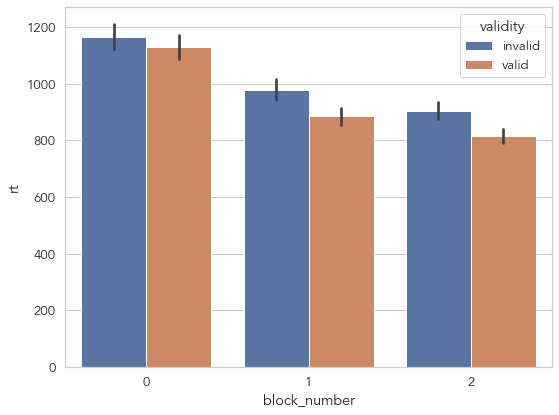

In [384]:
# are valid trials faster?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip[~df_zip.flagRT], 
                y= "rt", 
                hue="validity",
                x="block_number")

plt.tight_layout()

### Part type (tall vs. wide)

Looks like wide might be a little easier

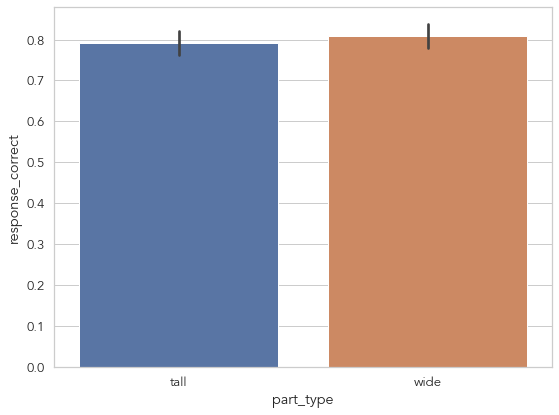

In [236]:
# Is either part type easier- accuracy?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip, 
                y= "response_correct", 
                x="part_type")

plt.tight_layout()

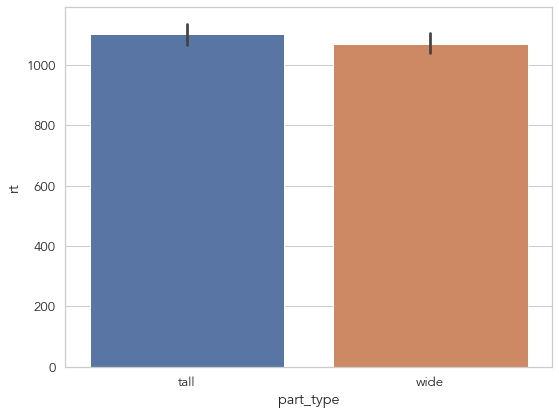

In [237]:
# Is either part type easier- rt?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip[~df_zip.flagRT], 
                y= "rt", 
                x="part_type")

plt.tight_layout()

### Stimuli

Are some stims easier than others?

In [303]:
import requests

In [304]:
stim_order = ['https://tower-4-block-unique-silhouettes-composite-silhouette-png.s3.amazonaws.com/tower_4_block_unique_silhouette_composites_silhouette_talls_100_118.png',
       'https://tower-4-block-unique-silhouettes-composite-silhouette-png.s3.amazonaws.com/tower_4_block_unique_silhouette_composites_silhouette_talls_122_127.png',
       'https://tower-4-block-unique-silhouettes-composite-silhouette-png.s3.amazonaws.com/tower_4_block_unique_silhouette_composites_silhouette_talls_102_126.png']

In [305]:
composite_id_order = [url.split('composites_silhouette_')[1].split('.')[0] for url in stim_order]
composite_id_order

['talls_100_118', 'talls_122_127', 'talls_102_126']

In [306]:
def show(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

talls_100_118


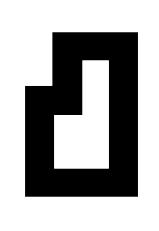

In [307]:
print(stim_order[0].split('silhouette_')[-1].split('.')[0])
show(stim_order[0])

talls_122_127


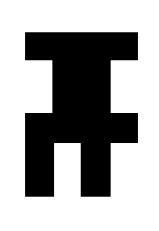

In [308]:
print(stim_order[1].split('silhouette_')[-1].split('.')[0])
show(stim_order[1])

talls_102_126


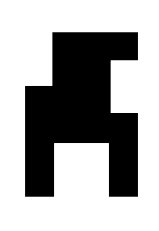

In [309]:
print(stim_order[2].split('silhouette_')[-1].split('.')[0])
show(stim_order[2])

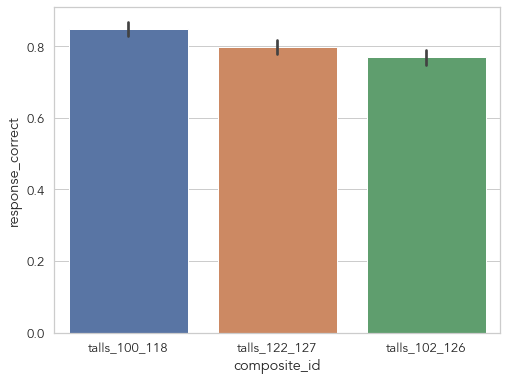

In [385]:
# Is either stimulus easier- accuracy?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip, 
                y= "response_correct", 
                x= "composite_id",
                order= composite_id_order)


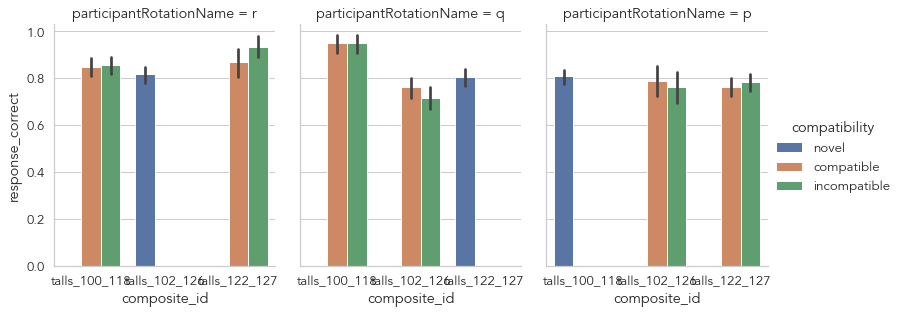

In [386]:
# Are people more accurate in compatible trials?

g = sns.catplot(col="participantRotationName", 
#                 x="validity",
                y="response_correct", 
                hue="compatibility",
                x="composite_id",
                hue_order=['novel','compatible','incompatible'],
                dodge=True,
                kind="bar",
                data=df_zip,
                height=4.6,
                aspect=0.8)

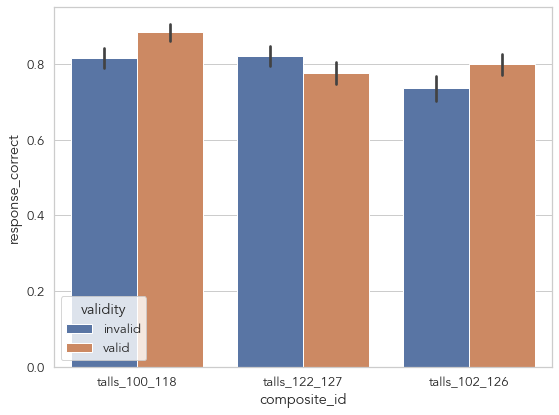

In [387]:
# Is either stimulus easier at saying one particular way?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip, 
                y= "response_correct", 
                x= "composite_id",
                hue="validity",
               order= composite_id_order)

plt.tight_layout()

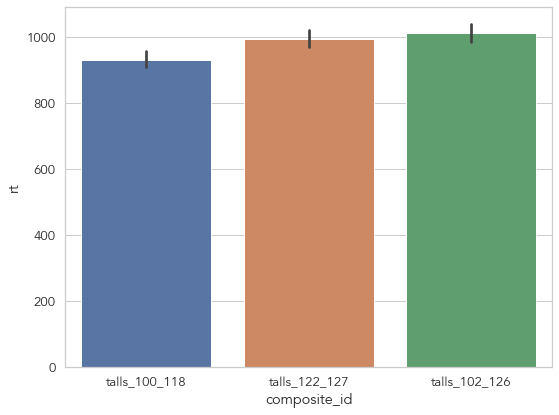

In [388]:
# Is either part type easier- rt?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip[~df_zip.flagRT], 
                y= "rt", 
                x= "composite_id",
                order= composite_id_order)

plt.tight_layout()

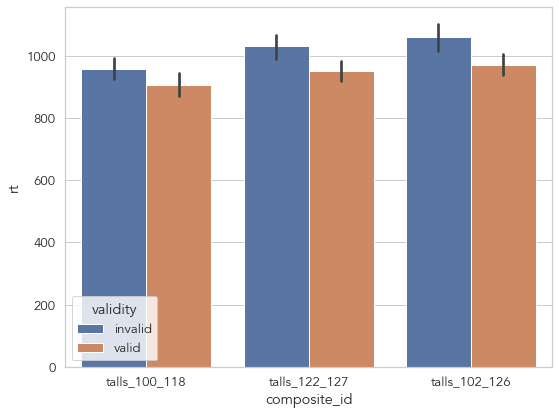

In [389]:
# Is either part type easier at saying one particular way- rt?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip[~df_zip.flagRT], 
                y= "rt", 
                x= "composite_id",
                order = composite_id_order,
                hue="validity")

plt.tight_layout()

In [303]:
df_zip.columns

Index(['Unnamed: 0', 'index', '_id', 'rt', 'stimulus', 'response',
       'response_correct', 'stimURL', 'composite_id', 'rep', 'block_number',
       'composite_duration', 'gap_duration', 'chunk_duration',
       'participant_condition', 'compatible_trial', 'validity',
       'composite_talls_name', 'composite_wides_name', 'part_type', 'part_a',
       'part_b', 'participantRotationName', 'participantRotation',
       'stimVersion', 'stimVersionInd', 'compatible_condition', 'trial_type',
       'trial_index', 'time_elapsed', 'internal_node_id', 'datatype',
       'experimentName', 'iterationName', 'workerID', 'gameID',
       'compatibility', 'trial_bin', 'flagRT'],
      dtype='object')

In [390]:
# Is either part type easier at saying one particular way?

fig = plt.figure(figsize=(8,6))

c = sns.lineplot(data=df_zip, 
                y= "response_correct", 
                x= "trial_bin",
                hue="validity")

plt.tight_layout()

ValueError: Could not interpret value `trial_bin` for parameter `x`

<Figure size 576x432 with 0 Axes>

## Stimuli

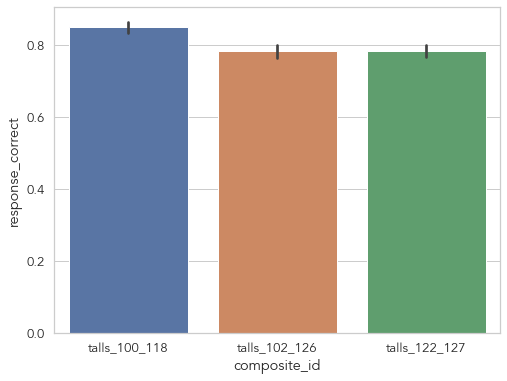

In [147]:
# Is either stimulus easier- accuracy?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip, 
                y= "response_correct", 
                x= "composite_id")
#                 hue="composite_id")


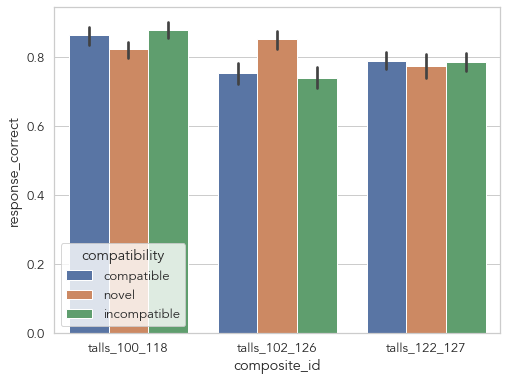

In [149]:
# Is either stimulus easier- accuracy?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip, 
                y= "response_correct", 
                x= "composite_id",
               hue="compatibility")


In [135]:
df_zip.columns

Index(['index', '_id', 'rt', 'stimulus', 'response', 'response_correct',
       'stimURL', 'composite_id', 'rep', 'block_number', 'composite_duration',
       'gap_duration', 'chunk_duration', 'participant_condition',
       'compatible_trial', 'validity', 'composite_talls_name',
       'composite_wides_name', 'part_type', 'part_a', 'part_b',
       'participantRotationName', 'participantRotation', 'stimVersion',
       'stimVersionInd', 'compatible_condition', 'trial_type', 'trial_index',
       'time_elapsed', 'internal_node_id', 'datatype', 'experimentName',
       'iterationName', 'gameID', 'compatibility', 'trial_bin', 'flagRT',
       'trial_num'],
      dtype='object')

In [128]:
df_zip[['participantRotation','participantRotationName']].iloc[0][0]

{'B': 'talls_122_127&wides_025_023',
 'novel': 'talls_102_126&wides_024_011',
 'A': 'talls_100_118&wides_013_010'}

In [132]:
df_zip[['participantRotation','participantRotationName']].iloc[200][0]

{'novel': 'talls_122_127&wides_025_023',
 'A': 'talls_102_126&wides_024_011',
 'B': 'talls_100_118&wides_013_010'}

In [ ]:
df_zip['participantRotation'][0]

In [339]:
df_zip.com

0       talls_100_
1       wides_025_
2       wides_013_
3       talls_122_
4       talls_100_
           ...    
1327    wides_024_
1328    wides_013_
1329    wides_011_
1330    wides_025_
1331    talls_126_
Name: part_a, Length: 1332, dtype: object

In [375]:
# part a
'composite_' + df_zip.part_type + 's_name'

0       composite_talls_name
1       composite_wides_name
2       composite_wides_name
3       composite_talls_name
4       composite_talls_name
                ...         
1327    composite_wides_name
1328    composite_wides_name
1329    composite_wides_name
1330    composite_wides_name
1331    composite_talls_name
Name: part_type, Length: 1332, dtype: object

In [388]:
df_zip.composite_talls_name.apply(lambda x: x.split('_')[-2:])

0       [122, 127]
1       [102, 126]
2       [122, 127]
3       [102, 126]
4       [100, 118]
           ...    
1327    [102, 126]
1328    [100, 118]
1329    [100, 118]
1330    [122, 127]
1331    [100, 118]
Name: composite_talls_name, Length: 1332, dtype: object

In [387]:
df_zip.composite_wides_name.apply(lambda x: x.split('_')[-2:])

0       [025, 023]
1       [024, 011]
2       [025, 023]
3       [024, 011]
4       [013, 010]
           ...    
1327    [024, 011]
1328    [013, 010]
1329    [013, 010]
1330    [025, 023]
1331    [013, 010]
Name: composite_wides_name, Length: 1332, dtype: object

In [392]:
# part a

df_zip.part_a.apply(lambda x: x.split('_')[1])

0       100
1       025
2       013
3       122
4       100
       ... 
1327    024
1328    013
1329    011
1330    025
1331    126
Name: part_a, Length: 1332, dtype: object

In [396]:
df_zip.columns

0       invalid
1       invalid
2       invalid
3       invalid
4         valid
         ...   
1327      valid
1328      valid
1329    invalid
1330    invalid
1331    invalid
Name: validity, Length: 1332, dtype: object

In [414]:
def check_parts(row):
    
    part_type = row.part_type
    part_a = row.part_a.split('_')[1]
    part_b = row.part_b.split('_')[1]
    
    
    if row.validity == 'valid':
        if part_type == 'tall':
            return part_type + 's_'+ part_a + '_' + part_b == row.composite_talls_name
        else:
            return part_type + 's_'+ part_a + '_' + part_b == row.composite_wides_name
    else: # invalid trials
        if part_type == 'wide':
            return (part_a not in row.composite_wides_name.split('_')[-2:]) and \
                   (part_b not in row.composite_wides_name.split('_')[-2:]) 
        else:
            return (part_a not in row.composite_talls_name.split('_')[-2:]) and \
                   (part_b not in row.composite_talls_name.split('_')[-2:]) 
    
    return (part_type, part_a, part_b)
    

dodgy_trials = df_zip.apply(lambda row: not check_parts(row), axis=1)


In [439]:
df_zip.columns

Index(['Unnamed: 0', 'index', '_id', 'rt', 'stimulus', 'response',
       'response_correct', 'stimURL', 'composite_id', 'rep', 'block_number',
       'composite_duration', 'gap_duration', 'chunk_duration',
       'participant_condition', 'compatible_trial', 'validity',
       'composite_talls_name', 'composite_wides_name', 'part_type', 'part_a',
       'part_b', 'participantRotationName', 'participantRotation',
       'stimVersion', 'stimVersionInd', 'compatible_condition', 'trial_type',
       'trial_index', 'time_elapsed', 'internal_node_id', 'datatype',
       'experimentName', 'iterationName', 'workerID', 'gameID',
       'compatibility', 'trial_bin', 'flagRT'],
      dtype='object')

In [458]:
df_zip[dodgy_trials][['gameID','part_a','part_b','part_type','composite_talls_name',
                      'composite_wides_name','validity','rep','compatibility']]#.groupby(['gameID','compatibility']).count()                     
                     
                     
                     

,gameID,part_a,part_b,part_type,composite_talls_name,composite_wides_name,validity,rep,compatibility
58,5932-1c8afdaa-3e62-4179-89e1-cac0c71b27a1,wide_025,wide_011,wide,talls_102_126,wides_024_011,invalid,2,compatible
67,5932-1c8afdaa-3e62-4179-89e1-cac0c71b27a1,tall_122,tall_126,tall,talls_102_126,wides_024_011,invalid,2,incompatible
88,7793-230b9c9f-94fe-4dc2-83cf-0b4841ee723f,tall_102,tall_118,tall,talls_100_118,wides_013_010,invalid,2,compatible
94,7793-230b9c9f-94fe-4dc2-83cf-0b4841ee723f,wide_024,wide_010,wide,talls_100_118,wides_013_010,invalid,2,incompatible
106,2420-26aa2daa-eb8b-4f9d-a573-bf768f18f3a2,wide_013,wide_023,wide,talls_122_127,wides_025_023,invalid,2,incompatible
...,...,...,...,...,...,...,...,...,...
1278,6103-27acfb95-944a-43dd-9c19-1a9b2bc27f86,wide_025,wide_010,wide,talls_122_127,wides_025_023,invalid,3,compatible
1316,6103-27acfb95-944a-43dd-9c19-1a9b2bc27f86,tall_100,tall_127,tall,talls_122_127,wides_025_023,invalid,2,incompatible
1317,6103-27acfb95-944a-43dd-9c19-1a9b2bc27f86,wide_013,wide_023,wide,talls_122_127,wides_025_023,invalid,2,compatible
1321,6103-27acfb95-944a-43dd-9c19-1a9b2bc27f86,tall_122,tall_118,tall,talls_122_127,wides_025_023,invalid,3,incompatible


In [443]:
# part b
df_zip.part_b.apply(lambda x: x.split('_')[1])

0       126
1       023
2       011
3       127
4       118
       ... 
1327    011
1328    010
1329    025
1330    010
1331    122
Name: part_b, Length: 1332, dtype: object

In [ ]:
# Is either stimulus easier- accuracy?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip, 
                y= "response_correct", 
                x= "participantRotationName",
                hue="compatibility")

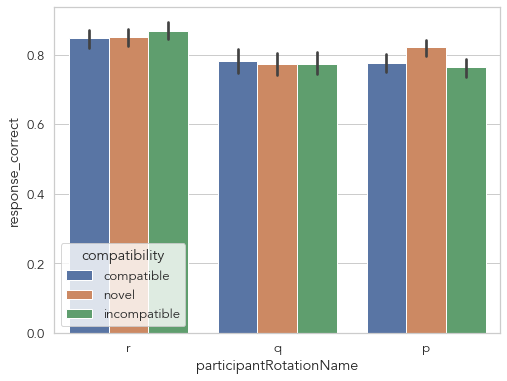

In [98]:
# Is either stimulus easier- accuracy?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip, 
                y= "response_correct", 
                x= "participantRotationName",
                hue="compatibility")

### Condition (A vs. B) - DOESN'T APPLY ANYMORE

Is one condition easier than the others?
A looks a bit easier.

In [238]:
# how many people in each condition
df_zip.groupby('gameID').first().value_counts('participant_condition')

participant_condition
1    5
2    5
dtype: int64

#### Participant condition

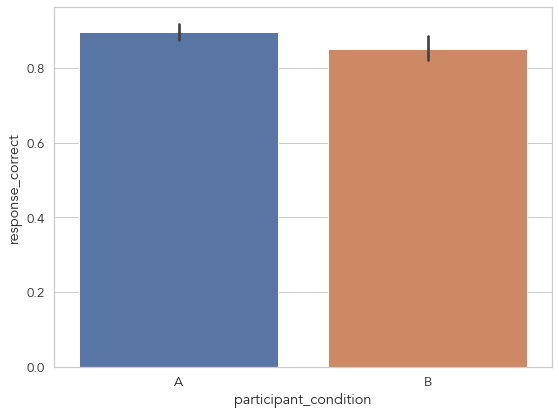

In [767]:
# Is either part type easier- accuracy?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip, 
                y= "response_correct", 
                x= "participant_condition")

plt.tight_layout()

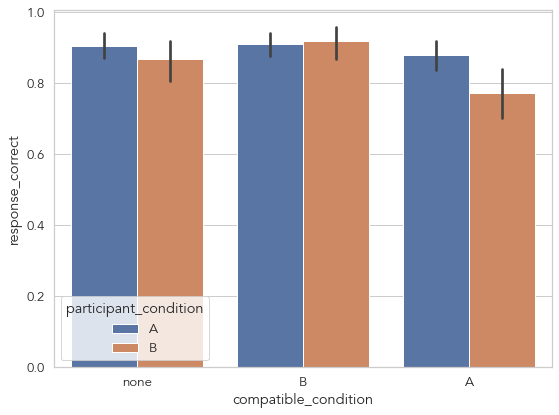

In [768]:
# break down by 

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip, 
                y= "response_correct", 
                x= "compatible_condition",
                hue="participant_condition")

plt.tight_layout()

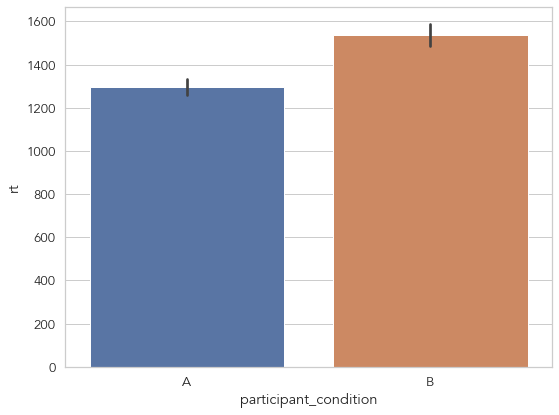

In [769]:
# Is either part type easier- rt?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip[~df_zip.flagRT], 
                y= "rt", 
                x= "participant_condition")

plt.tight_layout()

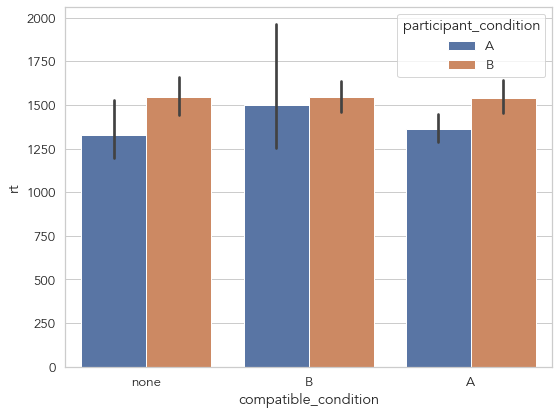

In [770]:
# Is either part type easier- accuracy?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip, 
                y= "rt", 
                x= "compatible_condition",
                hue="participant_condition")

plt.tight_layout()